# 05. Model 1: Decision Tree


# Contents

1. Introduction
2. Constructing our ML pipeline
3. One-hot encoding and scaling
4. Note on next steps for Sprint 3

In [1]:
# Importing essential libraries
import pandas as pd          
import numpy as np         
import matplotlib.pyplot as plt  
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


# 1. Introduction

In this notebook, we will build on our baseline modelling efforts, where we developed a logistic regression model predominantly using statsmodel.

Here, we construct a machine learning pipeline to train a **Decision Tree** model, starting by exploring ways to reduce dimensionality of our dataset using Principal Component Analysis, and then building on this to perform hyperparameter optimisation.


Loading our dataframe:

In [66]:
model1_df = pd.read_csv("/Users/niveditaprasad/Desktop/capstone_template/data_for_EDA/final_eda.csv")

In [67]:
model1_df.shape

(295323, 28)

# 2. Constructing our ML pipeline

To begin with, we'll explore constructing the following workflow:


1. Train-Test Split:

The data will be split into training and testing sets, using stratify=high_jobsat to ensure balanced splits of the target variable.

2. One-Hot Encoding & Scaling:

* Apply one-hot encoding to categorical features before scaling.
* Scale numerical features to normalize them for PCA.

3. PCA (Principal Component Analysis):

Apply PCA to reduce dimensionality while retaining 90% of the variance. This reduces complexity without losing too much information.

4. Visualize PCA:

Visualize the cumulative explained variance to determine how many components are needed.
Identify the most important features for PCA 1 and PCA 2.

**Note** We will update this notebook iteratively - for Sprint 2, the focus will be on starting our PCA, prior to fitting the Decision Tree model

## 1. Train, test split

Before launching into this, let's double check the datatypes in our df:

In [68]:
model1_df.dtypes

satisfaction_salary                  int64
satisfaction_advancement             int64
satisfaction_benefits                int64
satisfaction_challenges              int64
satisfaction_location                int64
satisfaction_security                int64
salary                             float64
importance_society_contribution      int64
job_degree_relation                  int64
recent_degree_field                 object
recent_degree_type                  object
age                                float64
marital_status                      object
citizenship_status                  object
children_in_household                int64
active_certifications              float64
survey_year                         object
occupation_name                     object
female                               int64
employer_sector                     object
employer_size_category              object
employer_region                     object
respondent_region                   object
ethnicity  

There's one column we forgot to drop which is likely redundant - we can drop citizenship_status which hold the same info as whether someone is a us citizen or not. This is also the case for survey_year vs survey date which was used for the purpose of constructing the job_duration_months variable, rather than being important as a standalone.

We'll keep in survey_year, given what we saw in our EDA about the potential impact of Covid on job satisfaction.

In [69]:
model1_df.drop(columns=['citizenship_status', 'survey_date'], inplace=True)

Assigning our X and y:

In [70]:
X = model1_df.drop('high_jobsat', axis=1)
y = model1_df['high_jobsat']

Reminding ourselves of datatypes present:

In [71]:
# Train-test split with stratification based on 'high_jobsat'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# 3. One-hot encoding and scaling

We will use sklearn's Column Transformer to support with this, naming this as a 'preprocessor':

In [72]:
# Detect categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()  # Select all non-object columns as numerical

In [73]:
categorical_features

['recent_degree_field',
 'recent_degree_type',
 'marital_status',
 'survey_year',
 'occupation_name',
 'employer_sector',
 'employer_size_category',
 'employer_region',
 'respondent_region',
 'ethnicity']

In [74]:
numerical_features

['satisfaction_salary',
 'satisfaction_advancement',
 'satisfaction_benefits',
 'satisfaction_challenges',
 'satisfaction_location',
 'satisfaction_security',
 'salary',
 'importance_society_contribution',
 'job_degree_relation',
 'age',
 'children_in_household',
 'active_certifications',
 'female',
 'job_duration_months',
 'us_citizen']

In [75]:
# Use ColumnTransformer to handle scaling for numeric and one-hot encoding for categorical; handle_unkown lets us safely handle unseen categories when it comes to the test data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Scale numeric features
        ('cat', OneHotEncoder(drop='first',handle_unknown='ignore', sparse_output=False), categorical_features)  # One-hot encode categorical features, ensuring drop first is set to true
    ]
)

## 4. Explore applying PCA for dimensionality reduction

We will epxlore applying principal component analysis to reduce the dimensionality of our dataset. By using n_components=80, we make a start in exploring the number of PCA components which we will in the next iterations and beyond further optimise. For now, this is an initial exploration.

Any transformation (such as scaling, one-hot encoding, or PCA) applied to the training data must also be applied to the test data. The model is trained on preprocessed features, so the test data needs to be transformed in the same way to match the training data's feature space.

(a) Applying PCA

In [76]:
# Create a pipeline to scale after one-hot encoding, then apply PCA
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply the ColumnTransformer for one-hot encoding
    ('scaler', StandardScaler()),  # Apply scaling after one-hot encoding
    ('pca', PCA(n_components=250))  # Apply PCA to reduce to 250 components, compared to the nearly 300 features
])

# Fit the pipeline on the training data
pipeline.fit(X_train)

# Transform the training and test data using the fitted pipeline
X_train_pca = pipeline.transform(X_train)
X_test_pca = pipeline.transform(X_test)

# Output the explained variance ratio by PCA
explained_variance = pipeline.named_steps['pca'].explained_variance_ratio_

# Print the cumulative explained variance
print(f"Cumulative explained variance (250 components): {explained_variance.cumsum()[-1]}")


Cumulative explained variance (250 components): 0.8998544761932469


(b) Plotting cumulative explained variance:

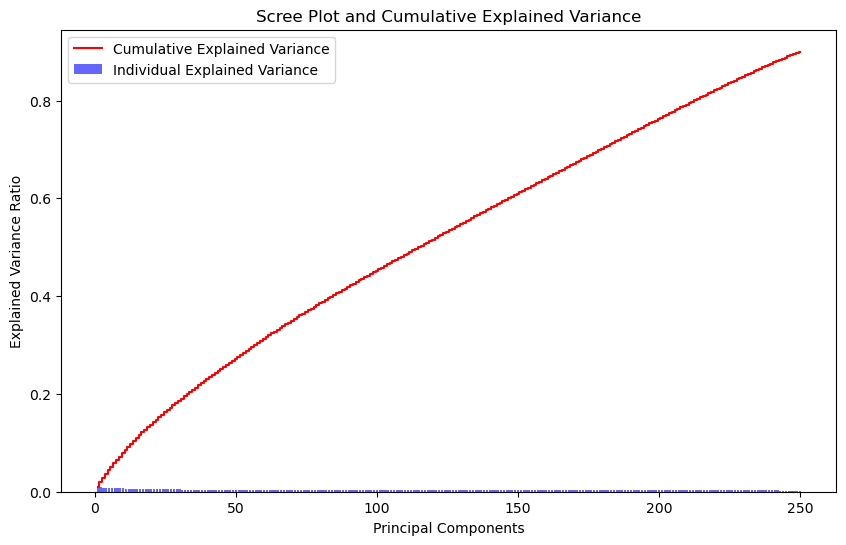

In [77]:
#Scree Plot

plt.figure(figsize=(10,6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, color='b', label='Individual Explained Variance')
plt.step(range(1, len(explained_variance) + 1), explained_variance.cumsum(), where='mid', label='Cumulative Explained Variance', color='r')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Scree Plot and Cumulative Explained Variance')
plt.legend(loc='best')
plt.show()

The scree plot shows both the individual explained variance of each principal component and the cumulative explained variance as more components are added.

From the plot, it loks like a large number of components are reuqired to explain a sufficient amount of th evariance (i.e., the 90% mark). Whilst we might have expected a sharper elbow, we see that the sumulative variance line is increasing quite steadily, and variance is more evenly distirbuted across components than may have been expected with other datasets.

It would be helpful to understand the loadings for PC1 and PC2 a bit better, to get a sense of feature importance:

In [78]:
# Get the preprocessed feature names (after one-hot encoding)
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Access the PCA components (loadings)
pca_components = pipeline.named_steps['pca'].components_

# Create a DataFrame for easy interpretation
pca_df = pd.DataFrame(pca_components, columns=feature_names)

# Get the absolute value of the loadings (important for feature importance)
abs_pca_df = np.abs(pca_df)

# Identify the top contributing features for the first principal component (PC1)
top_features_pc1 = abs_pca_df.iloc[0].sort_values(ascending=False)[:10]
print("Top 10 Features Contributing to PC1:")
print(top_features_pc1)

# Identify the top contributing features for the second principal component (PC2)
top_features_pc2 = abs_pca_df.iloc[1].sort_values(ascending=False)[:10]
print("\nTop 10 Features Contributing to PC2:")
print(top_features_pc2)


Top 10 Features Contributing to PC1:
num__satisfaction_challenges         0.325321
num__satisfaction_salary             0.323354
num__satisfaction_advancement        0.313906
num__satisfaction_benefits           0.269272
num__satisfaction_security           0.257569
num__salary                          0.247370
cat__marital_status_Married          0.239262
cat__marital_status_Never married    0.224245
num__job_degree_relation             0.212520
num__satisfaction_location           0.178157
Name: 0, dtype: float64

Top 10 Features Contributing to PC2:
cat__employer_sector_Educational Institution                                       0.345562
cat__respondent_region_Pacific                                                     0.272568
cat__employer_region_Pacific                                                       0.272540
num__female                                                                        0.221191
num__active_certifications                                               

Plotting this further:

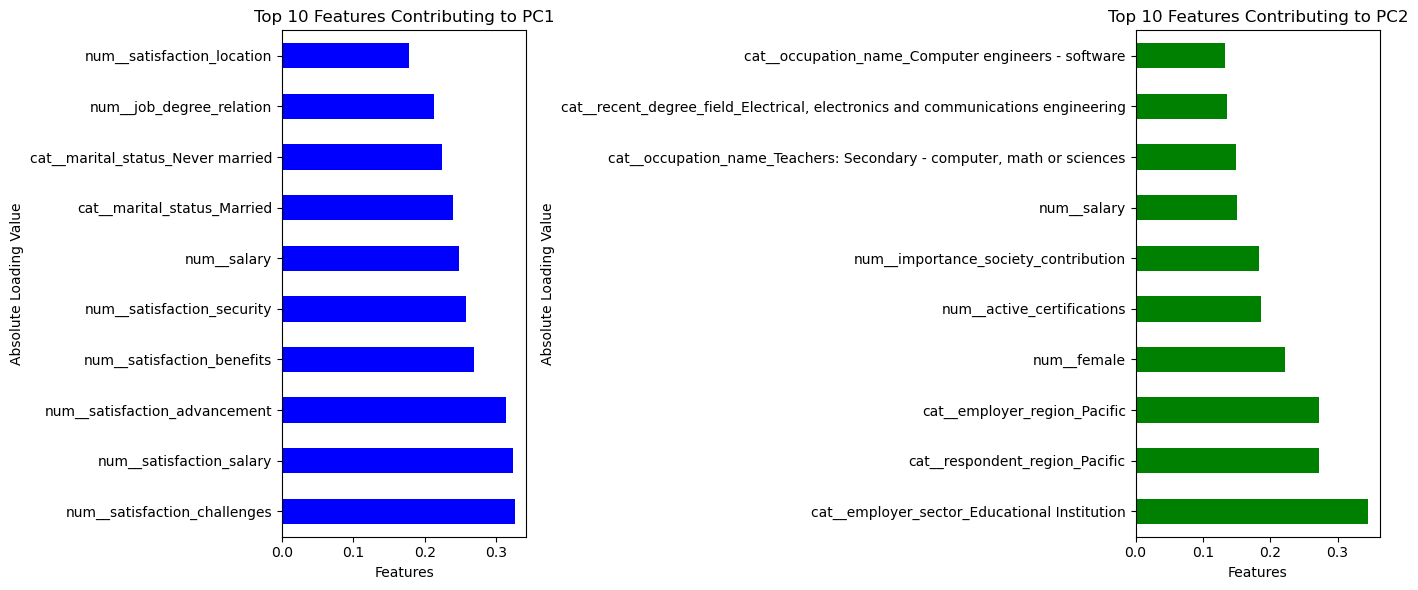

In [80]:
# Plot PC1 and PC2 side by side
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

# PC1
top_features_pc1.plot(kind='barh', color='blue', ax=axes[0])
axes[0].set_title('Top 10 Features Contributing to PC1')
axes[0].set_ylabel('Absolute Loading Value')
axes[0].set_xlabel('Features')

# PC2
top_features_pc2.plot(kind='barh', color='green', ax=axes[1])
axes[1].set_title('Top 10 Features Contributing to PC2')
axes[1].set_ylabel('Absolute Loading Value')
axes[1].set_xlabel('Features')

plt.tight_layout()
plt.show()

## PC1

### Features relating to aspects of job satisfaction are all dominant contributors to PC1.

These features are directly related to different dimensions of job satisfaction. Since our target is high job satisfaction, PC1 likely captures the primary drivers of satisfaction, such as compensation, professional challenges, career advancement, job security, and benefits.

### Marital status may be correlated with high job satisfaction, or it may affect how individuals perceive certain aspects of their job, such as stability, work-life balance, or compensation

This could explain what we saw in our baseline logit model, in terms of being married being associated with higher odds of being highly satisfied in one's job.

## PC2

### We see salary appears again in PC2

PC2 includes features like employer sector, region which may be associated with different salary levels based on the region or industry. Therefore, salary could be indirectly related to these factors as well, which would explain why it contributes to PC2.

### Employer sector, degree and occupation

These are some of the more tradiitonal feature variables that we'd expect to see - these appear in PC2 suggesting feature importance in relation to job satisfaction.


# 4. Note on next steps for Sprint 3

We've made a start on the more advanced modelling. However, my next steps in this notebook will be to:

1. Further explore number of components used for Principal Component Analysis

2. Construct and fine-tune Decision Tree model

(a) Build an initial decision tree classifier on the PCA-transformed data as a baseline model, and using 5-fold cross-validation

(b) Perform a coarse analysis to understand how the tree is behaving with default hyperparameters (e.g., max_depth, min_samples_split, min_samples_leaf).

(c) Use RandomizedSearchCV to quickly search through a broader range of hyperparameters and find a good combination to get closer to the optimal parameters.

(d) After the coarse analysis and RandomizedSearchCV, use GridSearchCV to perform a more fine-grained search to finalize your decision tree's hyperparameters

3. Evaluate Model 1: Decision Tree, based on the best performing model before building this up further to construct a neural network model (in a new notebook)